<a href="https://colab.research.google.com/github/KevinCandra9999/colab-test/blob/main/notebooks/Recognizing_handwritten_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch; torch.manual_seed(0)
import torchvision

import numpy as np
import matplotlib.pyplot as plt

In [2]:
my_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    './train',
    train=True,
    download=True,
    transform=my_transforms
)

val_dataset = torchvision.datasets.MNIST(
    './eval',
    train=False,
    download=True,
    transform=my_transforms
)

100%|██████████| 9912422/9912422 [00:00<00:00, 91977185.28it/s]


Extracting ./train/MNIST/raw/train-images-idx3-ubyte.gz to ./train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34909421.85it/s]


Extracting ./train/MNIST/raw/train-labels-idx1-ubyte.gz to ./train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28297775.33it/s]


Extracting ./train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4706158.29it/s]


Extracting ./train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 109931361.81it/s]

Extracting ./eval/MNIST/raw/train-images-idx3-ubyte.gz to ./eval/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 36785816.53it/s]


Extracting ./eval/MNIST/raw/train-labels-idx1-ubyte.gz to ./eval/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29191569.08it/s]


Extracting ./eval/MNIST/raw/t10k-images-idx3-ubyte.gz to ./eval/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17854291.25it/s]

Extracting ./eval/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./eval/MNIST/raw



In [3]:
print(train_dataset)
print(val_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./train
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./eval
    Split: Test
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [4]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

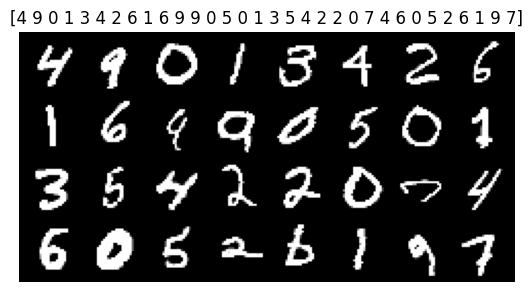

In [6]:
for images, labels in train_loader:
    grid = torchvision.utils.make_grid(images)

    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title(labels.numpy())
    plt.axis('off')

    plt.show()

    break

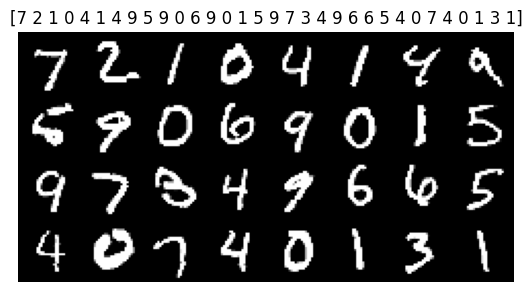

In [7]:
for images, labels in val_loader:
    grid = torchvision.utils.make_grid(images)

    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title(labels.numpy())
    plt.axis('off')

    plt.show()

    break

In [8]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [9]:
class DigitNet(torch.nn.Module):
    def __init__(self, hidden_size1, hidden_size2):
        super(DigitNet, self).__init__()
        self.linear1 = torch.nn.Linear(28 * 28, hidden_size1)
        self.relu1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = torch.nn.ReLU()
        self.output = torch.nn.Linear(hidden_size2, 10)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.output(out)

        return out

In [10]:
n_epochs = 10
learning_rate = 0.001

model = DigitNet(128, 128)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [11]:
if torch.cuda.is_available():
    print('CUDA is available. Using the GPU.')
    device = torch.device('cuda')
else:
    print('CUDA is not available. Using the CPU.')
    device = torch.device('cpu')

CUDA is available. Using the GPU.


In [12]:
model = model.to(device)
losses = []

for epoch in range(n_epochs):
    running_loss = 0

    for images, labels in train_loader:
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch + 1}/{n_epochs}: {losses[-1]:.4f}')

Epoch 1/10: 62.8866
Epoch 2/10: 26.8959
Epoch 3/10: 15.9691
Epoch 4/10: 13.0750
Epoch 5/10: 11.7109
Epoch 6/10: 10.8693
Epoch 7/10: 10.2520
Epoch 8/10: 9.7632
Epoch 9/10: 9.3766
Epoch 10/10: 9.0094


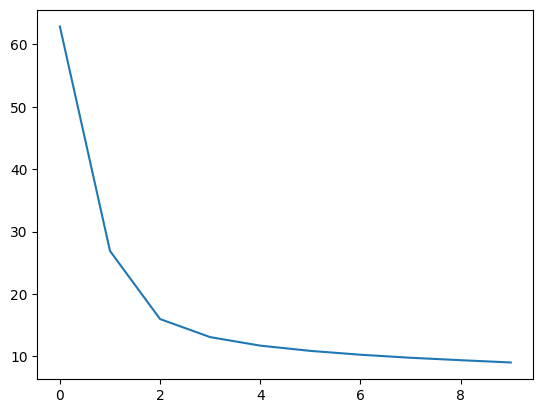

In [13]:
plt.plot(losses)
plt.show()

In [14]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        output = model(images)
        _, preds = torch.max(output.data, 1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

Accuracy: 92.07%


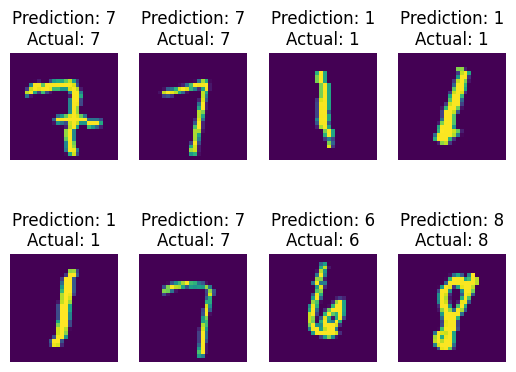

In [16]:
import random

n_images = 8

with torch.no_grad():
    for i in range(n_images):
        plt.subplot(2, n_images // 2, i + 1)
        index = random.randint(0, total - 1)
        img, label = val_dataset[index]

        temp_img = img.reshape(-1, 28 * 28).to(device)
        output = model(temp_img)
        _, pred = torch.max(output.data, 1)

        plt.imshow(img.squeeze(0).numpy())
        plt.title(f'Prediction: {pred.item()}\nActual: {label}')
        plt.axis('off')

    plt.show()

In [17]:
model1 = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)

model1

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
)

In [18]:
model

DigitNet(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=128, out_features=10, bias=True)
)

In [19]:
model2 = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10)
)

model2

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)